# Запись видео в  Colab

In [1]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

from IPython.display import HTML
from base64 import b64encode

In [2]:
def record_video(filename='video.mp4'):
  js = Javascript("""
    async function recordVideo() {
      // mashes together the advanced_outputs.ipynb function provided by Colab,
      // a bunch of stuff from Stack overflow, and some sample code from:
      // https://developer.mozilla.org/en-US/docs/Web/API/MediaStream_Recording_API

      // Optional frames per second argument.
      const options = { mimeType: "video/webm; codecs=vp9" }; //vp9
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");
      //capture.textContent = "Start Recording";
      capture.textContent = "Начать запись видео";
      capture.style.background = "green";
      capture.style.color = "white";

      //stopCapture.textContent = "Stop Recording";
      stopCapture.textContent = "Завершить запись видео";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);

      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      // create a media recorder instance, which is an object
      // that will let you record what you stream.
      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);
      // Video is a media element.  This line here sets the object which serves
      // as the source of the media associated with the HTMLMediaElement
      // Here, we'll set it equal to the stream.
      video.srcObject = stream;
      // We're inside an async function, so this await will fire off the playing
      // of a video. It returns a Promise which is resolved when playback has
      // been successfully started. Since this is async, the function will be
      // paused until this has started playing.
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      // and now, just wait for the capture button to get clicked in order to
      // start recording
      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);
      // use a promise to tell it to stop recording
      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();

      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();

      // stop the stream and remove the video element
      stream.getVideoTracks()[0].stop();
      div.remove();

      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
      return btoa(binaryString);
    }
    """)
  try:
    display(js)
    data = eval_js('recordVideo({})')
    binary = b64decode(data)
    with open(filename, "wb") as video_file:
      video_file.write(binary)
    print(

        f"Запись видео закончена. Путь к вашему файлу: {filename}"
    )
  except Exception as err:
      # In case any exceptions arise
      print(str(err))
  return filename



def play_video(filename, height=512, width=512):
    mp4 = open(filename, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f"""
    <video width={width} height={height} controls>
          <source src={data_url} type="video/mp4">
    </video>""")

### Запись

In [20]:
directory = '/content/'
filename = 'video.mp4'
video_path = record_video(directory+filename)

<IPython.core.display.Javascript object>

Запись видео закончена. Путь к вашему файлу: /content/video.mp4


### Просмотр

In [4]:
play_video(video_path)

Output hidden; open in https://colab.research.google.com to view.

# Детекция зрачков

## Необходимые библиотеки

In [5]:
#!pip install opencv-python -q
!pip install dlib -q

### Детектор и маска на лицо

In [6]:
# load predictor landmarks
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2025-10-28 09:31:28--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-10-28 09:31:28--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  31.6MB/s    in 1.9s    

2025-10-28 09:31:31 (31.6 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



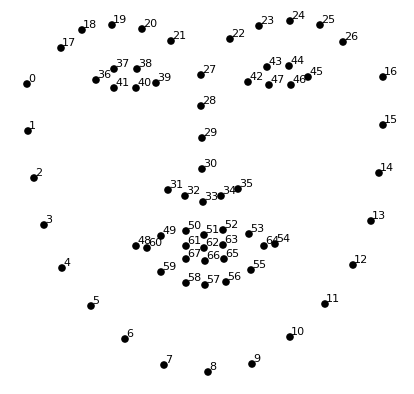

## Функции для формирования bbox зрачка

In [7]:
import cv2
import imutils
import numpy as np
import PIL
import dlib

from matplotlib import pyplot as plt

In [8]:
def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((68, 2), dtype=dtype)
	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	# return the list of (x, y)-coordinates
	return coords



def eye_on_mask(mask, shape, side):
    points = [shape[i] for i in side]
    points = np.array(points, dtype=np.int32)
    mask = cv2.fillConvexPoly(mask, points, 255)
    return mask

def blob_process(img, level):
    eyes_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(eyes_gray, level, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=3) #1
    thresh = cv2.dilate(thresh, None, iterations=4) #2
    thresh = cv2.medianBlur(thresh, 5) #3
    thresh = cv2.bitwise_not(thresh)
    return thresh

def pupil_coor(thresh, mid, img):
    sides = (thresh[:, 0:mid], thresh[:, mid:])
    pupils = []
    for i, side in enumerate(sides):
        try:
          cnts, _ = cv2.findContours(side, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[-2:]
          cnts = sorted(cnts, key=cv2.contourArea)
          cnt = max(cnts, key = cv2.contourArea)
          M = cv2.moments(cnt)
          cx = int(M['m10']/M['m00'])
          cy = int(M['m01']/M['m00'])
          if i: cx+=mid
          pupils.append((cx, cy))
        except: pupils.append((False, False))
    return pupils


def get_eyes_1(img, coor_face, predictor, eyes_marks):
    left, right = eyes_marks
    kernel = np.ones((9, 9), np.uint8)

    rect = dlib.rectangle(coor_face[0], coor_face[1], coor_face[2], coor_face[3])
    shape = predictor(img, rect)
    shape = shape_to_np(shape)

    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    mask = eye_on_mask(mask, shape, left)
    mask = eye_on_mask(mask, shape, right)
    mask = cv2.dilate(mask, kernel, 5)


    eyes = cv2.bitwise_and(img, img, mask=mask)
    mask = (eyes == [0, 0, 0]).all(axis=2)
    eyes[mask] = [255, 255, 255]

    mid = (shape[42][0] + shape[39][0]) // 2
    return eyes, mid


def get_square_box(box):
    """Get a square box out of the given box, by expanding it."""
    left_x = box[0]
    top_y = box[1]
    right_x = box[2]
    bottom_y = box[3]

    box_width = right_x - left_x
    box_height = bottom_y - top_y

    # Check if box is already a square. If not, make it a square.
    diff = box_height - box_width
    delta = int(abs(diff) / 2)

    if diff == 0:                   # Already a square.
        return box
    elif diff > 0:                  # Height > width, a slim box.
        left_x -= delta
        right_x += delta
        if diff % 2 == 1:
            right_x += 1
    else:                           # Width > height, a short box.
        top_y -= delta
        bottom_y += delta
        if diff % 2 == 1:
            bottom_y += 1

    # Make sure box is always square.
    assert ((right_x - left_x) == (bottom_y - top_y)), 'Box is not square.'

    return [left_x, top_y, right_x, bottom_y]


def move_box(box, offset):
        """Move the box to direction specified by vector offset"""
        left_x = box[0] + offset[0]
        top_y = box[1] + offset[1]
        right_x = box[2] + offset[0]
        bottom_y = box[3] + offset[1]
        return [left_x, top_y, right_x, bottom_y]

## Фиксация bbox зрачков детектором и ведение трекером

In [9]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2025-10-28 09:32:28--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.002s  

Last-modified header missing -- time-stamps turned off.
2025-10-28 09:32:28 (11.1 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2025-10-28 09:32:28--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

Создаем детектор и предиктор маски

In [10]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
cnn_detector = cv2.dnn.readNetFromCaffe(prototxt, model)

predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')

[INFO] loading model...


Параметры детекции

In [11]:
left = [36, 37, 38, 39, 40, 41]
right = [42, 43, 44, 45, 46, 47]
eyes_marks = (left, right)

dopusk = (80, 40)
level = 65

In [21]:
from imutils.video import FPS
# Функции для возпроизведение видео с результатом
from moviepy.editor import *

In [22]:
input_file = '/content/video.mp4'
cap = cv2.VideoCapture(input_file)

record_fps = 27 # cap.get(cv2.CAP_PROP_FPS)

record_w, record_h = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out_file = directory + 'Control_pupils.mp4'
writer = cv2.VideoWriter(out_file, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
                         record_fps, (record_w, record_h))


friq_detection = 7

history = []
hist_count  = [0]
history_faces = []

ret = True
count = 0
detected = False
fps = FPS()
fps.start()

while ret:
    # Capture frame-by-frame
    ret, frame = cap.read()

    if ret:
        #print(f'deteced {detected}')
        if not detected or (detected and not count % friq_detection):
            #print('detecting')
            # resize it to have a maximum width of 400 pixels
            #frame = imutils.resize(frame, width=400)
            (h_frame, w_frame) = frame.shape[:2]

            # сканирование для обнаружения лица
            blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
            cnn_detector.setInput(blob)
            detections = cnn_detector.forward()

            # сканирование для обнаружения лица
            probs = detections[0, 0, :, 2]
            probs = probs[probs > 0.5]
            #print('probs ', probs)
            q_faces = len(probs)

            if q_faces:
                # сборщик треккеров
                eyes_trackers = [[None, None] for _ in range(q_faces)]
                # сборщик координат боксов зрачков
                pupil_boxes = [[[None, None, None, None], [None, None, None, None]] for _ in range(q_faces)]
                # сбор уровня детекции в кадре - обнаружение лица
                hist_count = [0.33*prob for prob in probs]
                # есть ли обнаружение лица
                detected = True

                for i in range(q_faces):
                  text = "{:.2f}%".format(probs[i] * 100)

                  # координаты лиц
                  box = detections[0, 0, i, 3:7] * np.array([w_frame, h_frame,
                                                             w_frame, h_frame])
                  box_coor =  box.astype("int")

                  # адаптация бокса под face_landmarks
                  offset_y = int(abs((box_coor[3] - box_coor[1]) * 0.1))
                  box_moved = move_box(box_coor, [0, offset_y])
                  mask_box = get_square_box(box_moved)

                  # картинка глаз точка серидины расстояния между глазами
                  eyes, mid = get_eyes_1(frame, mask_box, predictor, eyes_marks)
                  # вычищенное мзображение ч\б зрачков из eyes c tresh уровнем level
                  pupils_bw = blob_process(eyes, level)
                  # координаты обнаруженного зрачка
                  pupils = pupil_coor(pupils_bw, mid, frame)

                  # рисуем бокс лица
                  cv2.rectangle(frame, (box_coor[0], box_coor[1]), (box_coor[2], box_coor[3]), (255, 0, 0), 1)
                  text_y = box_coor[1] - 10 if box_coor[1] - 10 > 10 else box_coor[1] + 10
                  cv2.putText(frame, text, (box_coor[0]-10, text_y),	cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)


                  for j, pupil in enumerate(pupils):
                    if all(pupil):
                        # сбор уровня детекции в кадре - обнаружение зрачка
                        hist_count[i]+=0.33
                        # сзаписываем трекер зрачка
                        eyes_trackers[i][j] = dlib.correlation_tracker()
                        # берем координаты центра зрачка
                        x, y = pupil

                        # определяем координаты бокса, ширину и высоту от заданного выше dopusk
                        # вокруг зрачка с учетом отношения картинки к размеру лица
                        kx = abs(box_coor[2]-box_coor[0])/h_frame
                        ky = abs(box_coor[3]-box_coor[1])/w_frame

                        left = x - int(dopusk[0]*kx)
                        top = y - int(dopusk[1]* ky)
                        right = x + int(dopusk[0]*kx)
                        bottom = y + int(dopusk[1]*ky)
                        pupil_boxes[i][j] = [left, top, right, bottom]

                        #print(f'pupil_box_detected {pupil_boxes[i][j]}')
                        # инициализируем трекер на данных бокса
                        eyes_trackers[i][j].start_track(frame,
                                                  dlib.rectangle(pupil_boxes[i][j][0],
                                                                 pupil_boxes[i][j][1],
                                                                 pupil_boxes[i][j][2],
                                                                 pupil_boxes[i][j][3]))
                        # рисуем зрачок
                        cv2.circle(frame, (x, y), 4, (255,211,67), 3)

            # если нет детекции лиц
            else:
                detected = False
                # если на прошлом кадре были лица, обнуляем их историю в текущем кадре по лицам
                if q_faces:
                  hist_count = [0 for _ in range(q_faces)]
                  #pupil_coors = [[[None, None, None, None], [None, None, None, None]] for _ in range(q_faces)]
                # если на прошлом кадре были лица, обнуляем их историю в текущем кадре по лицу
                else:
                  hist_count = [0]
                  #pupil_coors = [[[None, None, None, None], [None, None, None, None]]]


        # если ранее была детекция, а сейчас трекинг
        if detected and count % friq_detection:
            #print('tracking')
            # продолжаем историю прошлого кадра
            hist_count = [0.33*history_faces[-1][i] for i in range(len(history_faces[-1]))]
            # идем по количеству лиц
            for i in  range(len(pupil_boxes)):
                # идем по зрачкам
                for j in range(2):
                    # если есть трекер зрачкам
                    if eyes_trackers[i][j]:
                      # обнавляем трекер
                      eyes_trackers[i][j].update(frame)

                      # берем бокс из трекера
                      position = eyes_trackers[i][j].get_position()
                      left = int(position.left())
                      top = int(position.top())
                      width = int(position.width())
                      height =  int(position.height())
                      pupil_boxes[i][j] = [left, top, left+width, top+height]

                      # дополняем историю от детекции зрачка
                      hist_count[i]+=0.33


        if detected:
            for i in range(len(pupil_boxes)):
                for j in range(len(pupil_boxes[0])):
                    if eyes_trackers[i][j]:
                        # получаем бокс
                        left, top, right, bottom =  pupil_boxes[i][j]
                        # если правый бокс
                        if j: cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)
                        # если левый бокс
                        else: cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)

        writer.write(frame)

        count+=1
        #print(count)
        history.append(hist_count)
        if list(probs) !=[]:
          history_faces.append(list(probs))
        else:  history_faces.append([0])
       # print('history_faces', history_faces)


    else:
        cap.release()
        print(f"Пеpапись c {count} кадрами и частотой детекции {friq_detection} окончена")
        writer.release()
        writer = None
        break
    # update the FPS counter
    fps.update()

# Высвобождаем ресурсы
cv2.destroyAllWindows()



# stop the timer and display FPS information
fps.stop()
print("[INFO] elapsed time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

Пеpапись c 171 кадрами и частотой детекции 7 окончена
[INFO] elapsed time: 6.84
[INFO] approx. FPS: 25.00


In [23]:
fps_of_video = int(cv2.VideoCapture(out_file).get(cv2.CAP_PROP_FPS))

# Извлекаем видео из заданного пути (куда мы ранее записыли видео через cv2)
clip=VideoFileClip(out_file)

# Отображаем видео в колабе
clip.ipython_display(width=640, fps=fps_of_video)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


# График детекции

Обработка истории для максимального кол-ва детектированных лиц

In [24]:
history

[[np.float32(0.98780227), np.float32(0.6484174)],
 [np.float32(0.98780227), np.float32(0.6484174)],
 [np.float32(0.98780227), np.float32(0.6484174)],
 [np.float32(0.98780227), np.float32(0.6484174)],
 [np.float32(0.98780227), np.float32(0.6484174)],
 [np.float32(0.98780227), np.float32(0.6484174)],
 [np.float32(0.98780227), np.float32(0.6484174)],
 [np.float32(0.65779227), np.float32(0.97619975)],
 [np.float32(0.65779227), np.float32(0.97619975)],
 [np.float32(0.65779227), np.float32(0.97619975)],
 [np.float32(0.65779227), np.float32(0.97619975)],
 [np.float32(0.65779227), np.float32(0.97619975)],
 [np.float32(0.65779227), np.float32(0.97619975)],
 [np.float32(0.65779227), np.float32(0.97619975)],
 [np.float32(0.98243964)],
 [np.float32(0.98243964)],
 [np.float32(0.98243964)],
 [np.float32(0.98243964)],
 [np.float32(0.98243964)],
 [np.float32(0.98243964)],
 [np.float32(0.98243964)],
 [np.float32(0.6596161), np.float32(0.65526915)],
 [np.float32(0.6596161), np.float32(0.65526915)],
 [np

In [25]:
max_faces = max([len(history_faces[i]) for i in range(len(history_faces))])
y = []
for i in range(len(history)):
  t = history[i]
  if len(t) < max_faces:
    t.extend([0 for _ in range(max_faces -len(history[i]))])
  y.append(t)

y = np.array(y)


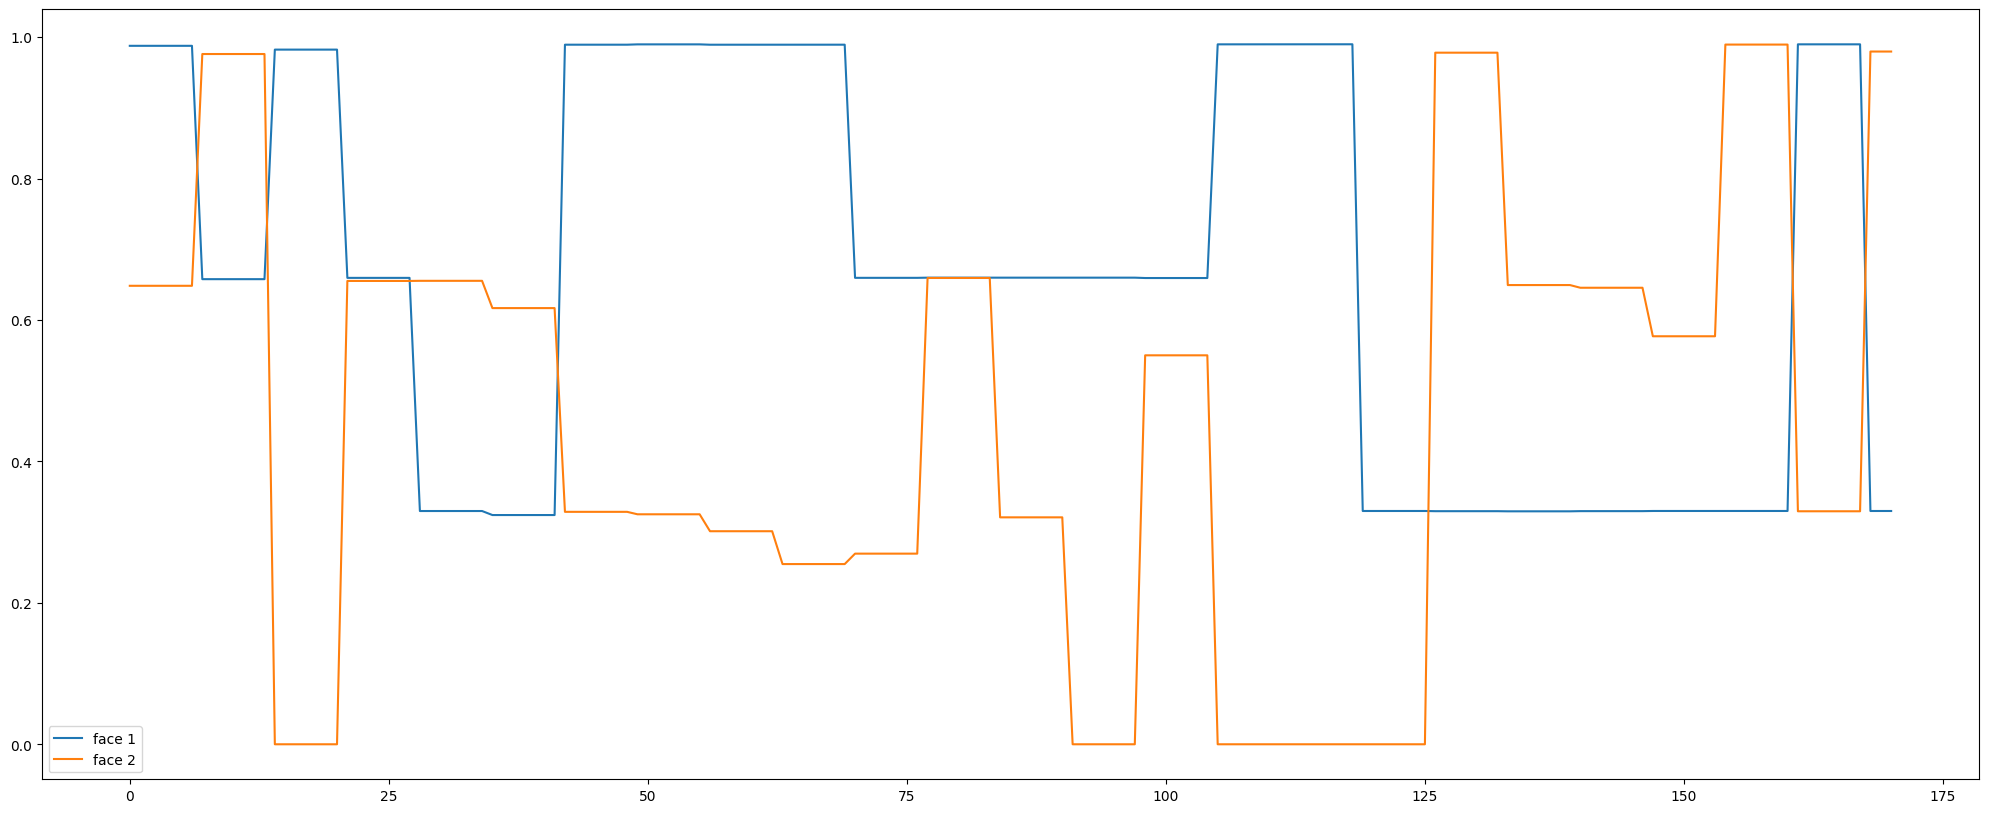

In [26]:
plt.figure(figsize=(25,10))
x = np.arange(len(history))
for i in range(max_faces):
  plt.plot(x, y[:, i], label = f'face {i+1}' )
plt.legend()
plt.show()
